Double checking that we are computing the expected final limiting surface brightness of Rubin correctly.



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
from rubin_sim.data import get_data_dir
import warnings

In [2]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
# The point on the sky we would like to get visits for
ra = [0.]
dec = [-20]

# Say we just want to pass data through, not compute anything. Documentation on the columns at: 
# https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'airmass', 'visitExposureTime',
                                      'numExposures','seeingFwhmEff', 'skybrightness', 'fiveSigmaDepth'])
# Let's do g and r
sql = 'filter ="g" or filter="r"'
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name))


In [4]:
bg = maf.metricBundles.MetricBundleGroup(bundleList, baseline_file, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database None with constraint filter ="g" or filter="r" for columns ['numExposures', 'fiveSigmaDepth', 'filter', 'airmass', 'observationStartMJD', 'rotSkyPos', 'fieldRA', 'seeingFwhmEff', 'visitExposureTime', 'fieldDec', 'skybrightness']
Found 657012 visits
Running:  ['baseline_nexp2_v1_7_10yrs_Pass_filter_observationStartMJD_airmass_visitExposureTime_numExposures_seeingFwhmEff_skybrightness_fiveSigmaDepth_g_or_r_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
data = bundleList[0].metricValues[0]
data

rec.array([(2, 24.43034532, 'r', 1.11074587, 62735.20207892, 122.24825875, 3.59358790e+02, 0.70838265, 30., -21.03796694, 21.01509174),
           (2, 24.56754417, 'g', 1.05742525, 62711.39390048, 238.78858792, 3.59666780e+02, 1.00073615, 30., -21.03166138, 22.06745447),
           (2, 24.3010774 , 'r', 1.03328378, 63418.43951074, 190.46954203, 3.58971481e+02, 0.73088639, 30., -20.92295587, 20.77290552),
           (2, 24.02701227, 'r', 1.04284328, 61330.07940052, 191.1572113 , 3.58737469e+02, 0.96957564, 30., -21.20443273, 20.85043192),
           (2, 24.10990171, 'r', 1.05674785, 61317.10864523,  63.3100428 , 3.59862696e+02, 0.96833556, 30., -21.64221479, 21.04357635),
           (2, 24.3565237 , 'g', 1.14329142, 63504.08667832,  60.44296263, 3.59793543e+02, 1.16292377, 30., -21.7432346 , 21.98870125),
           (2, 23.78501579, 'r', 1.06659794, 60507.4320486 , 174.75038595, 3.59071804e+02, 1.28099672, 30., -21.44231781, 20.99711126),
           (2, 24.87333962, 'g', 1.06971158, 627

In [6]:
np.where(data['filter'] == 'g')[0].size

80

In [7]:
sb_metric = maf.metrics.SurfaceBrightLimitMetric()

In [8]:
sb_metric.run(data[np.where(data['filter']=='r')], None)

30.324139568219938

In [9]:
sb_metric.run(data[np.where(data['filter']=='g')], None)

30.45779480638887

In [10]:
# Let's check the surface brightness limits per exposure
class PerVisitsb(maf.metrics.SurfaceBrightLimitMetric):
    def run(self, dataSlice, slicePoint):
        filtername = np.unique(dataSlice[self.filterCol])
        if np.size(filtername) > 1:
            ValueError(
                "Can only coadd depth in single filter, got filters %s" % filtername
            )
        filtername = filtername[0]

        # Scale up readnoise if the visit was split into multiple snaps
        readnoise = self.readnoise * np.sqrt(dataSlice[self.nexpCol])

        sb_per_visit = surface_brightness_limit_approx(
            self.zpt[filtername],
            self.kAtm[filtername],
            dataSlice[self.airmassCol],
            dataSlice[self.skybrightnessCol],
            rn=readnoise,
            pixscale=self.pixscale,
            nsigma=self.nsigma,
            t_exp=dataSlice[self.exptimeCol],
            tot_area=self.tot_area,
        )
        return sb_per_visit


In [11]:
def surface_brightness_limit_approx(
    zp,
    k,
    airmass,
    mu_sky,
    rn=8.8,
    pixscale=0.2,
    nsigma=3.0,
    t_exp=30.0,
    tot_area=100.0,
    mag_diff_warn=0.1,
):
    """Compute surface brightness limit in 3 limiting cases, return the brightest.

    Algerbra worked out in this technote:
    https://github.com/lsst-sims/smtn-016

    Parameters
    ---------
    zp : `float`
        Telescope zeropoint (mags)
    k : `float`
        Atmospheric extinction term
    airmass : `float`
        Airmass
    mu_sky : `float`
        Surface brightness of the sky (mag/sq arcsec)
    rn : `float` (8.8)
        Readnoise in electrons
    pixscale : `float` (0.2)
        Arcseconds per pixel
    nsigma : `float` (3)
        The SNR to demand
    t_exp : `float` (30.)
        Exposure time (seconds)
    tot_area : `float` (100)
        The total area measuring over (sq arcsec)
    mag_diff_warn : `float` (0.1)
        If the limiting cases are within mag_diff_warn, throw a warning
        that the surface brightness limit may be an overestimate.

    Returns
    -------
    surface brightness limit in mags/sq arcsec
    aka the surface brightness that reaches SNR=nsigma when measured over tot_area.
    """

    

    A_pix = pixscale ** 2
    n_pix = tot_area / A_pix

    # Sky limited case
    mu_sky_lim = (
        -1.25 * np.log10(nsigma ** 2 / (A_pix * t_exp * n_pix))
        + 0.5 * mu_sky
        + 0.5 * zp
        - k * airmass
    )

    # Source limited case
    # XXX--double check this algerbra. Pretty sure it's right now.
    mu_source_lim = (
        -1.25 * np.log10(nsigma)
        + 1.25 / 2.0 * np.log10(n_pix * A_pix * t_exp)
        + zp
        - k * airmass
    )

    # Readnoise limited case
    mu_rn_lim = (
        -2.5 * np.log10(nsigma * rn / (t_exp * A_pix * n_pix ** 0.5)) + zp - k * airmass
    )

    d1 = np.min(np.abs(mu_sky_lim - mu_source_lim))
    d2 = np.min(np.abs(mu_sky_lim - mu_rn_lim))
    d3 = np.min(np.abs(mu_rn_lim - mu_source_lim))

    if np.min([d1, d2, d3]) < mag_diff_warn:
        warnings.warn(
            "Limiting magnitudes in different cases are within %.3f mags, result may be too optimistic by up 0.38 mags/sq arcsec."
            % mag_diff_warn
        )

    result = np.vstack([mu_sky_lim, mu_source_lim, mu_rn_lim])
    result = np.min(result, axis=0)

    return result

In [12]:
per_vis_metric = PerVisitsb()
data_df = pd.DataFrame(data)
mu_3 = np.zeros(len(data), dtype=float)
for filtername in np.unique(data['filter']):
    in_filt = np.where(data['filter'] == filtername)[0]
    mu_3[in_filt] = per_vis_metric.run(data[in_filt], None)
    

Text(0, 0.5, '#')

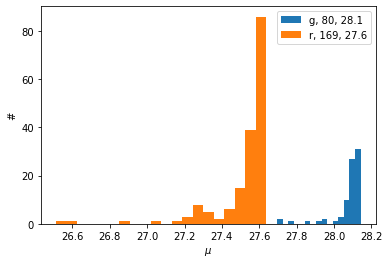

In [13]:
for filtername in np.unique(data['filter']):
    in_filt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(mu_3[in_filt],
                    label=filtername+', %i, %.1f' % (np.size(in_filt), np.median(mu_3[in_filt])),
                                                     bins=20)
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('#')

Looks like we have 80 g obervations with median depths of 27.2. And 170 observations in r with median depth 26.7.

Getting coadded $\mu_r=29.45$ and $\mu_g=29.58$ mag/ sq arcsec for 10x10 acrsec area

In [14]:
def coaddM5(mags):
    """Coadded depth, assuming Gaussian noise"""
    return 1.25 * np.log10(np.sum(10.0 ** (0.8 * np.array(mags))))

In [15]:
# ok, the coadding seems fine. 
# Does this make sense with SDSS stripe 82 values?
# from  Fliri & Trujillo 2015:
# Our reduction reaches a limit of ∼28.5 mag arcsec−2 (3σ, 10 × 10 arcsec2) in the r 
# Consequently, the single-pass SDSS imaging is superb for studies of low surface brightness features 
# (reaching down to ∼26.5 mag arcsec−2 through direct detection (3σ, 10 × 10 arcsec2)
# 53.9 s using a 2.5 m telescope
#  Stripe 82 area has been observed 80 times, only around 2/3 of the full available Stripe 82 data are useful 

In [16]:
-1.25*np.log10((2.5**2*54.)/(6.67**2*30.) ) + 26.5

27.246373931732144

In [17]:
per_vis_metric.zpt

{'u': 26.930630906256887,
 'g': 28.338556652285675,
 'r': 28.131005103939575,
 'i': 27.8413594264397,
 'z': 27.448741867001043,
 'y': 26.65798980004943}

In [18]:
from rubin_sim.photUtils import Bandpass, PhotometricParameters
datadir = get_data_dir()
filtername='r'
bp = Bandpass()
bp.readThroughput(
    os.path.join(
        datadir, "throughputs/baseline/", "total_%s.dat" % filtername
    ))
phot_params = PhotometricParameters(
                    nexp=1, gain=1, exptime=1, bandpass=filtername
                )
bp.calcZP_t(phot_params)

28.131005103939575

In [19]:
# Let's see if we get a reasonable surface brightness for a SDSS-like exposure
sdss_param = PhotometricParameters(exptime=1, nexp=1, effarea=(2.5/2*100)**2*np.pi, gain=1, readnoise=8., darkcurrent=0,
                                   othernoise=0)

In [20]:
sdss_zpts = {}
for filtername in 'gr':
    bp = Bandpass()
    bp.readThroughput(
    os.path.join(
        datadir, "throughputs/baseline/", "total_%s.dat" % filtername
    ))
    phot_params = PhotometricParameters(
                    nexp=1, gain=1, exptime=1, bandpass=filtername, effarea=(2.5/2*100)**2*np.pi
                )
    sdss_zpts[filtername] = bp.calcZP_t(phot_params)

sdss_zpts

{'g': 26.289567085575356, 'r': 26.08201553722926}

In [21]:
pv = PerVisitsb(zpt=sdss_zpts)

In [22]:
# update to sdss exposure time
data['visitExposureTime'] = 53.9
mu_3_sdss = np.zeros(len(data), dtype=float)
for filtername in np.unique(data['filter']):
    in_filt = np.where(data['filter'] == filtername)[0]
    mu_3_sdss[in_filt] = pv.run(data[in_filt], None)


/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_40807/1649231930.py:80: UserWarning: Limiting magnitudes in different cases are within 0.100 mags, result may be too optimistic by up 0.38 mags/sq arcsec.
  warnings.warn(


In [23]:
mu_3_sdss

array([26.8804091 , 27.21480472, 26.76906739, 26.80662718, 26.90144901,
       27.19645185, 26.87697647, 27.21217866, 27.20723435, 26.88728711,
       26.90784858, 26.90532864, 26.9070696 , 27.21841984, 26.9184138 ,
       26.9082298 , 26.80648006, 26.89435113, 27.21374177, 26.75879591,
       26.89465838, 27.20542471, 26.77148674, 26.89853816, 26.89762725,
       27.10378419, 26.6694536 , 26.87581829, 27.21286324, 25.80670935,
       26.83694384, 26.91259245, 27.19496358, 26.76198071, 26.84161463,
       27.2091313 , 26.90081448, 26.8948913 , 26.90205537, 26.90661836,
       26.85235829, 26.58891377, 27.20841335, 26.59737718, 26.60873072,
       26.83727673, 26.89938562, 26.82046623, 27.15854122, 26.77178603,
       27.19816878, 26.88994364, 26.86954044, 27.22386932, 26.54312704,
       26.47313304, 27.14477458, 27.21948787, 26.88836737, 26.87054081,
       27.21575751, 26.90167711, 26.89633698, 27.20716989, 26.89440612,
       26.84032784, 27.2100347 , 27.18592226, 26.88251446, 26.82

Text(0.5, 1.0, 'SDSS-size telescope')

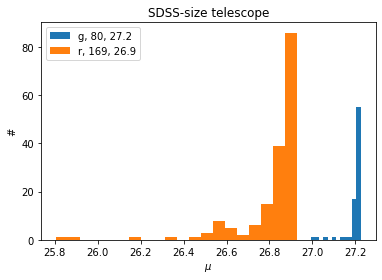

In [24]:
for filtername in np.unique(data['filter']):
    in_filt = np.where(data['filter'] == filtername)[0]
    _tmp = plt.hist(mu_3_sdss[in_filt],
                    label=filtername+', %i, %.1f' % (np.size(in_filt), np.median(mu_3_sdss[in_filt])),
                                                     bins=20)
plt.legend()
plt.xlabel('$\mu$')
plt.ylabel('#')
plt.title('SDSS-size telescope')

In [25]:
# OK, so: I get an SDSS-like telescope should have single-image depths of 26.0 mag/sq arcsec
# and I get Rubin should have single-visit depths of 26.7 mag/sq arcsec. Coadded to 29.45

# Now, folks find SDSS has actual single-visit depths of 26.5. And claim Rubin should get to ~30 coadded.

# So, Either there is a bug in the surface brightness code that's making a constant 0.5 mag offset,
# Or there's a bug in the telescope zeropoint code that is making a 1 mag offset. 